In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
from differentiable_lensing import DifferentiableLensing, shared_colorimshow
import data
from sisr import SISR

In [3]:
magnification = 2
n_mag = 1
residual_depth = 3
in_channels = 2
latent_space_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
target_resolution = 0.101/2
target_shape = 128

In [4]:
BATCH_SIZE = 1 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation

val_dataset_no_sub = data.LensingDataset('val/',['no_sub'],2000)
val_dataset_axion = data.LensingDataset('val/',['axion'],2000)
val_dataset_cdm = data.LensingDataset('val/',['cdm'],2000)

model = SISR(magnification=magnification, n_mag=n_mag, residual_depth=residual_depth, in_channels=in_channels, latent_channel_count=latent_space_size).to(device)
model.load_state_dict(torch.load('vdl_weights.pt'))
lensing_module = DifferentiableLensing(device=device, alpha=None, target_resolution=target_resolution, target_shape=target_shape).to(device)

cross_grid_to_log = torch.load('scatter_to_log_128.pt').to(device)
cross_grid_forward_from_log = torch.load('forward_from_log_128.pt').to(device)
cross_grid_from_log = torch.load('scatter_from_log_128.pt').to(device)
cross_grid_backward = torch.load('sparse_grid_fracs_euclid_backward.pt').to(device)

psf, _, _ = lensing_module.gaussian_kernel(fwhm_arcsec=0.16, pixscale_arcsec=target_resolution)
psf = torch.tensor(psf, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0).to(device)

In [5]:
def test_complete(dataset, image_indices):
    images_for_plot = []
    for index in image_indices:
        lr_image = dataset[index].float().to(device)

        # Source reconstruction through backward lensing
        reconstructed_source = lensing_module.cross_grid_fill(lr_image, [cross_grid_backward]) # rename to lensing

        # Upscaling using a neural network
        model_feed = torch.cat([reconstructed_source, lr_image], dim=1)
        with torch.no_grad():
            upscaled_source_ = model(model_feed)

        # Image construction through forward lensing
        upscaled_image_ = lensing_module.cross_grid_fill(upscaled_source_, [cross_grid_to_log, cross_grid_forward_from_log, cross_grid_from_log])
        convolved_upscaled_image_ = F.conv2d(upscaled_image_, psf, padding="same")
        images_for_plot.append(lr_image[0,0].cpu())
        images_for_plot.append(reconstructed_source[0,0].cpu())
        images_for_plot.append(upscaled_source_[0,0].cpu())
        images_for_plot.append(upscaled_image_[0,0].cpu())
        images_for_plot.append(convolved_upscaled_image_[0,0].cpu())
    return shared_colorimshow(images_for_plot, nrows=len(image_indices), ncols=5, cmap='grey')

def test_images(dataset, image_indices):
    images_for_plot = []
    for index in image_indices:
        lr_image = dataset[index].float().to(device)

        # Source reconstruction through backward lensing
        reconstructed_source = lensing_module.cross_grid_fill(lr_image, [cross_grid_backward]) # rename to lensing

        # Upscaling using a neural network
        model_feed = torch.cat([reconstructed_source, lr_image], dim=1)
        with torch.no_grad():
            upscaled_source_ = model(model_feed)

        # Image construction through forward lensing
        upscaled_image_ = lensing_module.cross_grid_fill(upscaled_source_, [cross_grid_to_log, cross_grid_forward_from_log, cross_grid_from_log])
        convolved_upscaled_image_ = F.conv2d(upscaled_image_, psf, padding="same")
        images_for_plot.append(lr_image[0,0].cpu())
        images_for_plot.append(upscaled_image_[0,0].cpu())
        images_for_plot.append(convolved_upscaled_image_[0,0].cpu())
    return shared_colorimshow(images_for_plot, nrows=len(image_indices), ncols=3, cmap='grey')

def test_inout(dataset, image_indices):
    images_for_plot = []
    titles = []
    for index in image_indices:
        lr_image = dataset[index].float().to(device)

        # Source reconstruction through backward lensing
        reconstructed_source = lensing_module.cross_grid_fill(lr_image, [cross_grid_backward]) # rename to lensing

        # Upscaling using a neural network
        model_feed = torch.cat([reconstructed_source, lr_image], dim=1)
        with torch.no_grad():
            upscaled_source_ = model(model_feed)

        # Image construction through forward lensing
        upscaled_image_ = lensing_module.cross_grid_fill(upscaled_source_, [cross_grid_to_log, cross_grid_forward_from_log, cross_grid_from_log])
        convolved_upscaled_image_ = F.conv2d(upscaled_image_, psf, padding="same")
        images_for_plot.append(lr_image[0,0].cpu())
        images_for_plot.append(convolved_upscaled_image_[0,0].cpu())
        titles.append('LR observed image')
        titles.append('SR approximation')
    return shared_colorimshow(images_for_plot, nrows=len(image_indices), ncols=2, cmap='grey', set_title=titles)

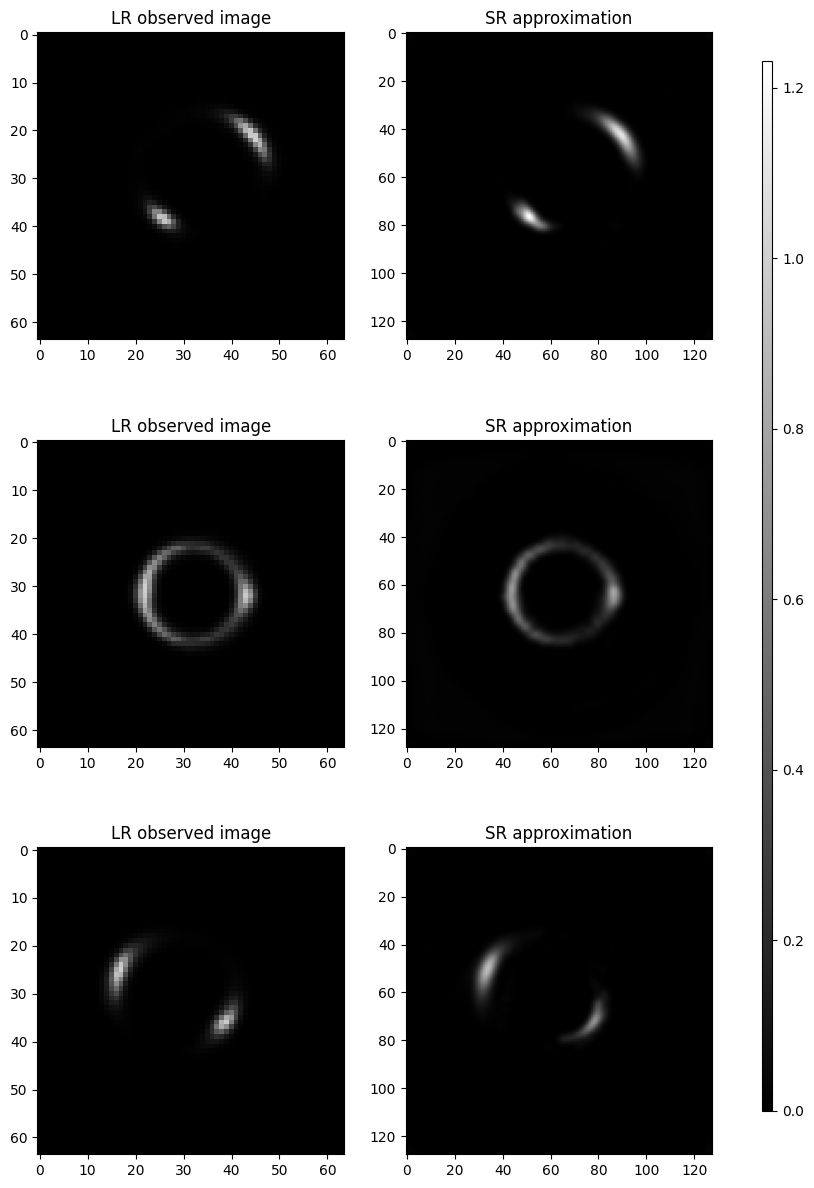

In [6]:
plot, axes = test_inout(val_dataset_no_sub, [4,5,6])
plot.savefig('first_results.pdf')